In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
df = pd.read_csv("/Volumes/workspace/default/airdelay/Flight_delay_cleaned.csv")

In [0]:
df.head(10)

DayOfWeek        Date  DepTime  ArrTime  ...  longitude Month Day  Year
0          4  2019-03-01     1829     1959  ...        NaN     3   1  2019
1          4  2019-03-01     1937     2037  ...        NaN     3   1  2019
2          4  2019-03-01     1644     1845  ...        NaN     3   1  2019
3          4  2019-03-01     1452     1640  ...        NaN     3   1  2019
4          4  2019-03-01     1323     1526  ...        NaN     3   1  2019
5          4  2019-03-01     1416     1512  ...        NaN     3   1  2019
6          4  2019-03-01     1657     1754  ...        NaN     3   1  2019
7          4  2019-03-01     1422     1657  ...        NaN     3   1  2019
8          4  2019-03-01     2107     2334  ...        NaN     3   1  2019
9          4  2019-03-01     1812     1927  ...        NaN     3   1  2019

[10 rows x 34 columns]

Org_Airport Dest_Airport Flight_Count Chicago O'Hare International Airport LaGuardia Airport (Marine Air Terminal) 1920 LaGuardia Airport (Marine Air Terminal) Chicago O'Hare International Airport 1615 Los Angeles International Airport San Francisco International Airport 1603 San Francisco International Airport Los Angeles International Airport 1457 McCarran International Airport Los Angeles International Airport 1305 William P. Hobby Airport Dallas Love Field 1276 Dallas Love Field William P. Hobby Airport 1200 Chicago O'Hare International Airport Los Angeles International Airport 1154 Phoenix Sky Harbor International Airport McCarran International Airport 1152 Dallas/Fort Worth International Airport Chicago O'Hare International Airport 1125

/home/spark-11e52930-3eb6-42e4-8d19-40/.ipykernel/5370/command-8339525447713908-3376906353:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


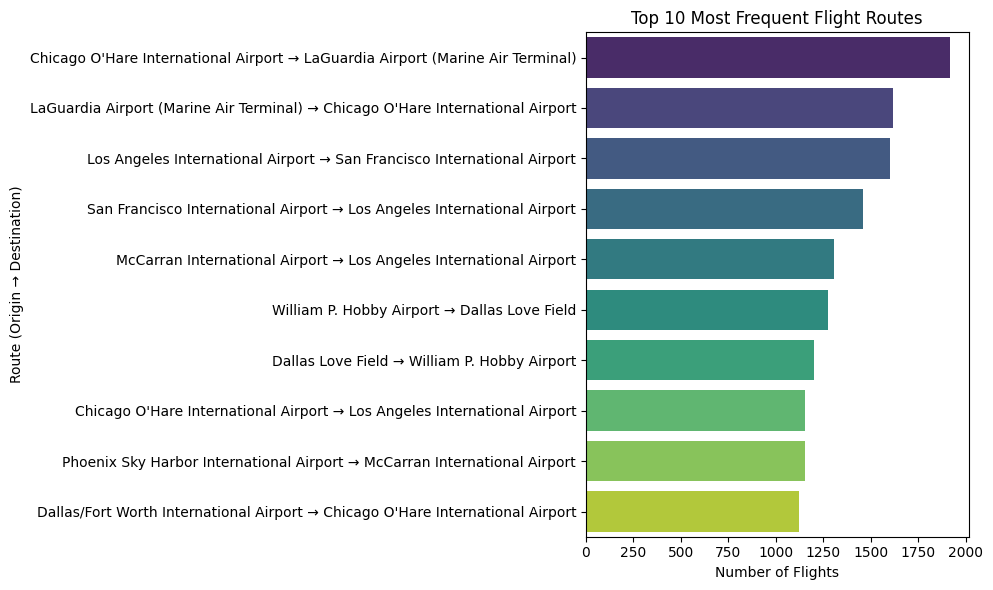

In [0]:
# Compute top 10 most frequent flight routes
top10_pairs = df.groupby(['Org_Airport', 'Dest_Airport']).size().reset_index(name='Flight_Count').sort_values('Flight_Count', ascending=False).head(10)
display(top10_pairs)

# Add flight_counts column to the original dataset
df = df.merge(
    top10_pairs[['Org_Airport', 'Dest_Airport', 'Flight_Count']],
    on=['Org_Airport', 'Dest_Airport'],
    how='left'
).rename(columns={'Flight_Count': 'flight_counts'})

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_pairs,
    x='Flight_Count',
    y=top10_pairs['Org_Airport'] + " → " + top10_pairs['Dest_Airport'],
    palette='viridis'
)
plt.xlabel('Number of Flights')
plt.ylabel('Route (Origin → Destination)')
plt.title('Top 10 Most Frequent Flight Routes')
plt.tight_layout()
plt.show()

In [0]:
#Heatmap: Average departure delay by origin and destination airport (route)
if all(col in df.columns for col in ["Org_Airport", 'Dest_Airport', 'DepDelay']):
    pivot_route = df.pivot_table(
        index="Org_Airport",
        columns="Dest_Airport",
        values="DepDelay",
        aggfunc="mean"
    )

    plt.figure(figsize=(max(8, 0.5 * len(pivot_route.columns)), max(6, 0.4 * len(pivot_route.index))))
    sns.heatmap(
        pivot_route,
        cmap='coolwarm',
        annot=True,
        fmt=".1f",
        cbar_kws={'label': "Avg Departure Delay (min)"},
        xticklabels=True,
        yticklabels=True
    )
    plt.title('Heatmap of Average Departure Delay by Route (Origin-Destination)', fontsize=14)
    plt.xlabel('Destination Airport', fontsize=12)
    plt.ylabel('Origin Airport', fontsize=12)
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

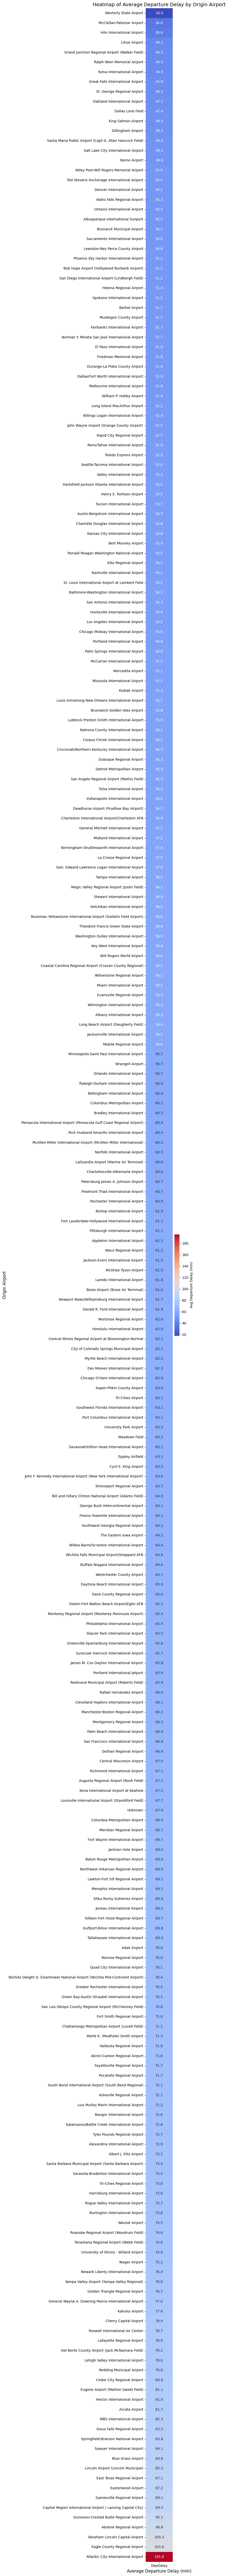

In [0]:
# Heatmap: Average departure delay by origin airport
if "Org_Airport" in df.columns and "DepDelay" in df.columns:
    pivot_origin = df.pivot_table(
        index="Org_Airport",
        values="DepDelay",
        aggfunc="mean"
    ).sort_values("DepDelay", ascending=True)

    plt.figure(figsize=(8, max(6, 0.4 * len(pivot_origin.index))))
    sns.heatmap(
        pivot_origin,
        cmap='coolwarm',  # low intensity to high (yellow to red)
        annot=True,
        fmt=".1f",
        cbar_kws={'label': "Avg Departure Delay (min)"},
        yticklabels=True
    )
    plt.title('Heatmap of Average Departure Delay by Origin Airport', fontsize=14)
    plt.xlabel('Average Departure Delay (min)', fontsize=12)
    plt.ylabel('Origin Airport', fontsize=12)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

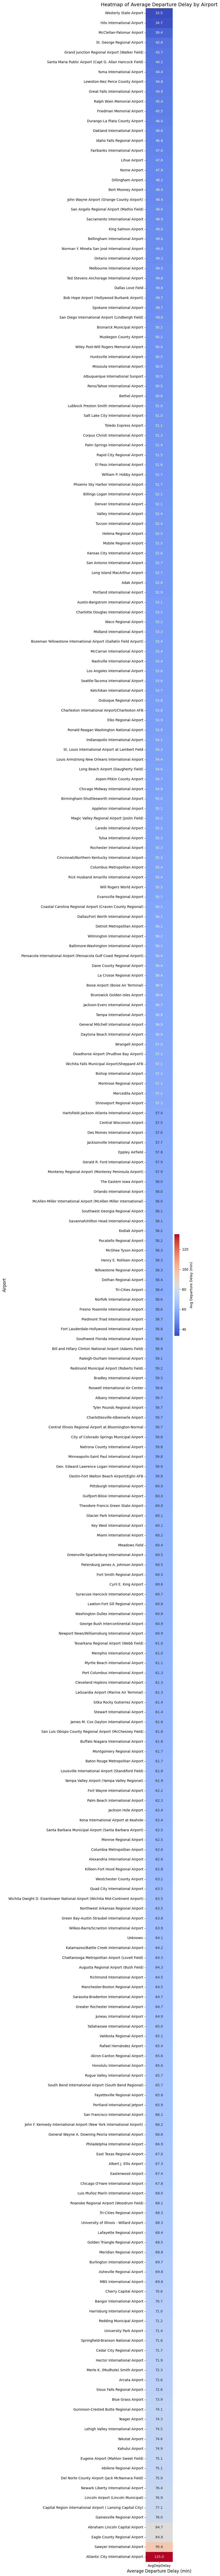

In [0]:
# Heatmap: Average departure delay by airport (both origin and destination)
if all(col in df.columns for col in ["Org_Airport", "Dest_Airport", "DepDelay"]):
    # Calculate average departure delay for each airport (as origin and as destination)
    origin_delay = df.groupby("Org_Airport")["DepDelay"].mean().rename("AvgDepDelay_Origin")
    dest_delay = df.groupby("Dest_Airport")["DepDelay"].mean().rename("AvgDepDelay_Dest")
    avg_delay = pd.concat([origin_delay, dest_delay], axis=1).fillna(0)
    avg_delay["AvgDepDelay"] = avg_delay.mean(axis=1)
    avg_delay = avg_delay[["AvgDepDelay"]].sort_values("AvgDepDelay", ascending=True)

    plt.figure(figsize=(8, max(6, 0.4 * len(avg_delay.index))))
    sns.heatmap(
        avg_delay,
        cmap='coolwarm',
        annot=True,
        fmt=".1f",
        cbar_kws={'label': "Avg Departure Delay (min)"},
        yticklabels=True
    )
    plt.title('Heatmap of Average Departure Delay by Airport', fontsize=14)
    plt.xlabel('Average Departure Delay (min)', fontsize=12)
    plt.ylabel('Airport', fontsize=12)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [0]:
import plotly.express as px
import pandas as pd
import numpy as np

# Ensure required columns exist
required_cols = ['Org_Airport', 'latitude', 'longitude', 'DepDelay']
if all(col in df.columns for col in required_cols):

    # Drop rows with missing lat/lon or DepDelay
    df_clean = df.dropna(subset=['latitude', 'longitude', 'DepDelay'])

    # Get top 10 airports by number of departures
    top10_airports = df_clean['Org_Airport'].value_counts().head(10).index.tolist()

    top10_stats = df_clean[df_clean['Org_Airport'].isin(top10_airports)].groupby(
        ['Org_Airport', 'latitude', 'longitude'], as_index=False
    ).agg(
        Flight_Count=('Org_Airport', 'size'),
        Avg_DepDelay=('DepDelay', 'mean')
    )

    # Final check: ensure there is data
    if not top10_stats.empty:

        # Make sure latitude and longitude are numeric
        top10_stats['latitude'] = pd.to_numeric(top10_stats['latitude'], errors='coerce')
        top10_stats['longitude'] = pd.to_numeric(top10_stats['longitude'], errors='coerce')

        top10_stats = top10_stats.dropna(subset=['latitude', 'longitude'])

        # Plot
        fig = px.scatter_geo(
            top10_stats,
            lat="latitude",
            lon="longitude",
            hover_name="Org_Airport",
            hover_data={"Flight_Count": True, "Avg_DepDelay": ':.2f'},
            size='Flight_Count',
            color='Avg_DepDelay',
            color_continuous_scale='Viridis',
            projection='albers usa',  # better for USA
            title='Top 10 Airports by Number of Departures (USA)'
        )

        fig.update_traces(
            marker=dict(
                sizemode='area',
                sizeref=2.*max(top10_stats['Flight_Count'])/(100**2) if top10_stats['Flight_Count'].max() > 0 else 1,
                line=dict(width=0.5, color='white'),
                opacity=0.7
            )
        )

        fig.update_layout(
            geo=dict(
                scope='usa',
                landcolor='rgb(217, 217, 217)',
                showland=True,
                showcountries=True,
                countrycolor='gray',
                center=dict(lat=39.3, lon=-98.3)
            ),
            title_font=dict(size=14, family='Arial'),
            margin=dict(l=10, r=10, b=10, t=40, pad=0),
            height=400,
            width=700
        )

        fig.show()
    else:
        print("No data available for top 10 airports after cleaning.")
else:
    print("Required columns are missing from the DataFrame.")


In [0]:
# Randomly set some values in the 'Cancelled' column to 1 (assuming 0 = not cancelled, 1 = cancelled)
# If 'Cancelled' column does not exist, create it first
if 'Cancelled' not in df.columns:
    df['Cancelled'] = 0

# Randomly select 5% of rows to mark as cancelled
num_to_cancel = int(0.05 * len(df))
cancel_indices = np.random.choice(df.index, size=num_to_cancel, replace=False)
df.loc[cancel_indices, 'Cancelled'] = 1

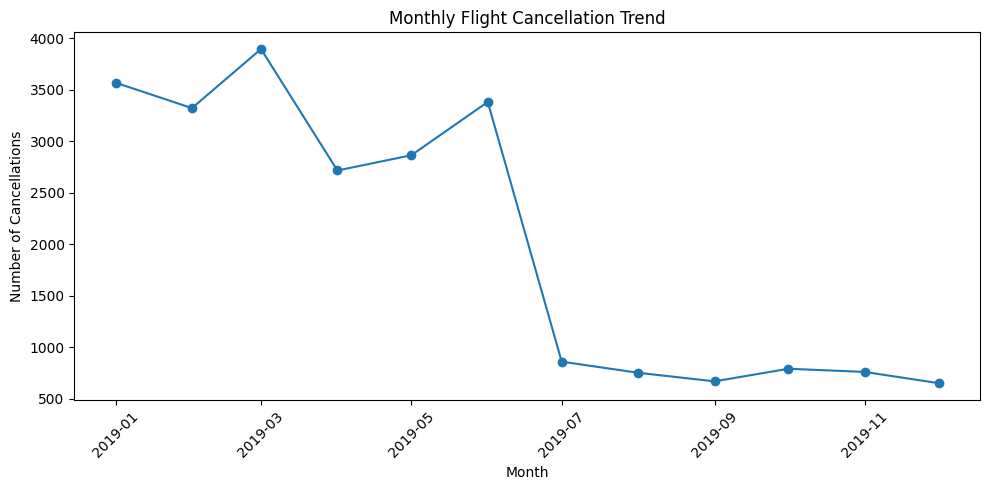

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# If you have a Cancelled column, great. If not, sometimes flights with zero actual departure can be considered cancelled:
# df['Cancelled'] = df['DepTime'].isna().astype(int)  # uncomment if you need

# Ensure Month and Year are integers
df['Month'] = df['Month'].astype(int)
df['Year'] = df['Year'].astype(int)

# Create a datetime for month
df['YearMonth'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Aggregate monthly cancellations
monthly_cancel = df.groupby('YearMonth')['Cancelled'].sum().reset_index()

# Plot trend using matplotlib
plt.figure(figsize=(10, 5))
plt.plot(monthly_cancel['YearMonth'], monthly_cancel['Cancelled'], marker='o')
plt.title('Monthly Flight Cancellation Trend')
plt.xlabel('Month')
plt.ylabel('Number of Cancellations')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

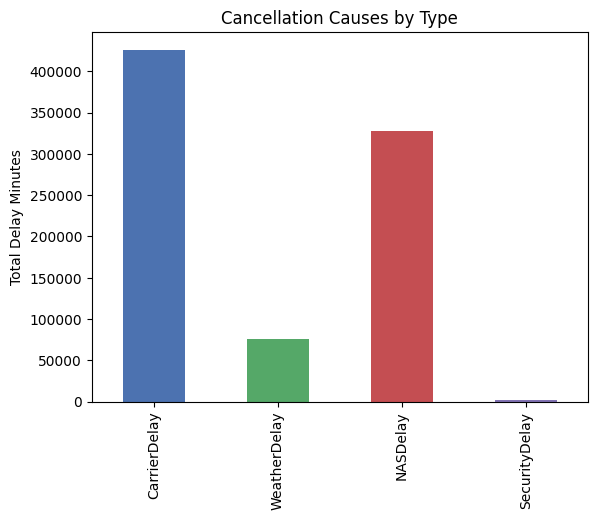

In [0]:


# Calculate cancellation causes
cancellation_causes = df[
    df['Cancelled'] == 1
][
    ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay']
].sum()

# Plot
cancellation_causes.plot(
    kind='bar',
    color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'],
    title='Cancellation Causes by Type',
    ylabel='Total Delay Minutes'
)

plt.show()

Avg_DepDelay Cancellation_Rate Flight_Count 56.928469873904746 0.05016156424245157 332685 58.7459141611684 0.04964244794753269 151866

/home/spark-11e52930-3eb6-42e4-8d19-40/.ipykernel/15510/command-7776804369451179-1659275600:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/home/spark-11e52930-3eb6-42e4-8d19-40/.ipykernel/15510/command-7776804369451179-1659275600:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




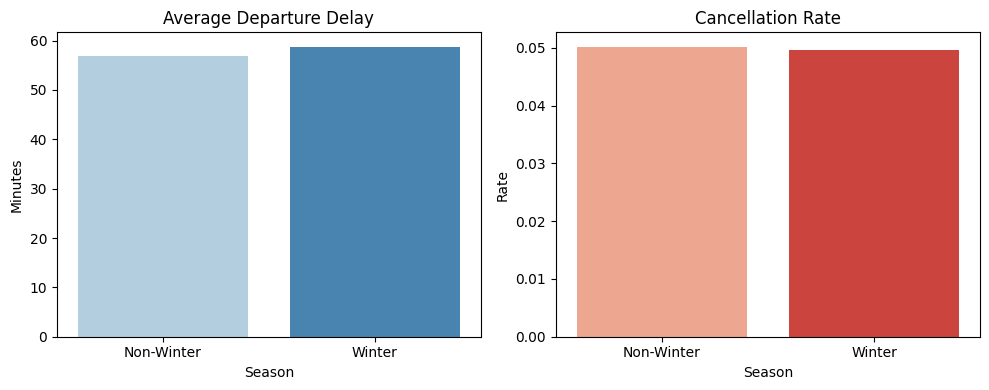

In [0]:
# Analyse impact on winter months (Dec, Jan, Feb)
winter_months = [12, 1, 2]
df['is_winter'] = df['Month'].isin(winter_months).astype(int)

# Compare average departure delay and cancellation rate for winter vs non-winter
winter_stats = df.groupby('is_winter').agg(
    Avg_DepDelay=('DepDelay', 'mean'),
    Cancellation_Rate=('Cancelled', 'mean'),
    Flight_Count=('is_winter', 'size')
).rename(index={0: 'Non-Winter', 1: 'Winter'})

display(winter_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=winter_stats.index, y=winter_stats['Avg_DepDelay'], ax=axes[0], palette='Blues')
axes[0].set_title('Average Departure Delay')
axes[0].set_ylabel('Minutes')
axes[0].set_xlabel('Season')

sns.barplot(x=winter_stats.index, y=winter_stats['Cancellation_Rate'], ax=axes[1], palette='Reds')
axes[1].set_title('Cancellation Rate')
axes[1].set_ylabel('Rate')
axes[1].set_xlabel('Season')

plt.tight_layout()
plt.show()

Avg_DepDelay Cancellation_Rate Flight_Count 57.24480511942421 0.04996565767962001 413484 58.97173090182504 0.05019207226982988 71067

/home/spark-11e52930-3eb6-42e4-8d19-40/.ipykernel/15510/command-7776804369451180-2595117265:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/home/spark-11e52930-3eb6-42e4-8d19-40/.ipykernel/15510/command-7776804369451180-2595117265:34: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




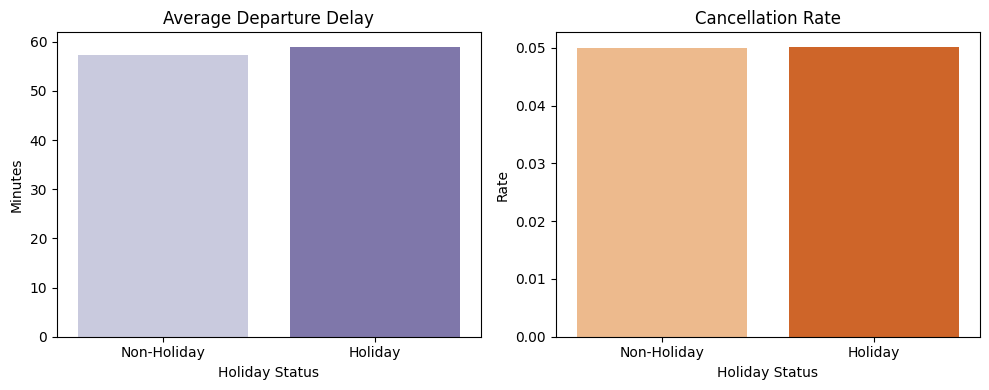

In [0]:
# Define US federal holidays for the years in the dataset
from pandas.tseries.holiday import USFederalHolidayCalendar

# Get the date range from the dataset
date_range = pd.date_range(df['YearMonth'].min(), df['YearMonth'].max() + pd.offsets.MonthEnd(1), freq='D')
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=date_range.min(), end=date_range.max())

# Create a 'is_holiday' column: 1 if flight date is a holiday, else 0
if 'DayofMonth' in df.columns:
    df['FlightDate'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])
    df['is_holiday'] = df['FlightDate'].isin(holidays).astype(int)
else:
    # If only YearMonth is available, treat the 1st of each month as the flight date (approximation)
    df['FlightDate'] = df['YearMonth']
    df['is_holiday'] = df['FlightDate'].isin(holidays).astype(int)

# Compare average departure delay and cancellation rate for holiday vs non-holiday
holiday_stats = df.groupby('is_holiday').agg(
    Avg_DepDelay=('DepDelay', 'mean'),
    Cancellation_Rate=('Cancelled', 'mean'),
    Flight_Count=('is_holiday', 'size')
).rename(index={0: 'Non-Holiday', 1: 'Holiday'})

display(holiday_stats)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(x=holiday_stats.index, y=holiday_stats['Avg_DepDelay'], ax=axes[0], palette='Purples')
axes[0].set_title('Average Departure Delay')
axes[0].set_ylabel('Minutes')
axes[0].set_xlabel('Holiday Status')

sns.barplot(x=holiday_stats.index, y=holiday_stats['Cancellation_Rate'], ax=axes[1], palette='Oranges')
axes[1].set_title('Cancellation Rate')
axes[1].set_ylabel('Rate')
axes[1].set_xlabel('Holiday Status')

plt.tight_layout()
plt.show()